# Expert Opinion Survey processing

In [ ]:
source("notebooks/initialize-data-analysis.r")


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

# Spaghetti code warning

In [ ]:
library(tidyverse)
library(ggstats)
library(gtsummary)


In [ ]:
data_survey <- read_csv("data/data-original-processed/survey_results.csv") |>
  select(-comorb_hematological)


Rows: 16 Columns: 67
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (67): patient_age, patient_age_65, patient_sex, patient_weight, patient_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

In [ ]:
data_survey_factor <- data_survey |>
  mutate(across(everything(), ~ factor(.x, levels = c(1:5))))


In [ ]:
# gglikert(data_survey_factor, sort = "descending", sort_method = "mean")
# gglikert_stacked(data_survey_factor, sort = "descending", sort_method = "mean", add_median_line = TRUE)


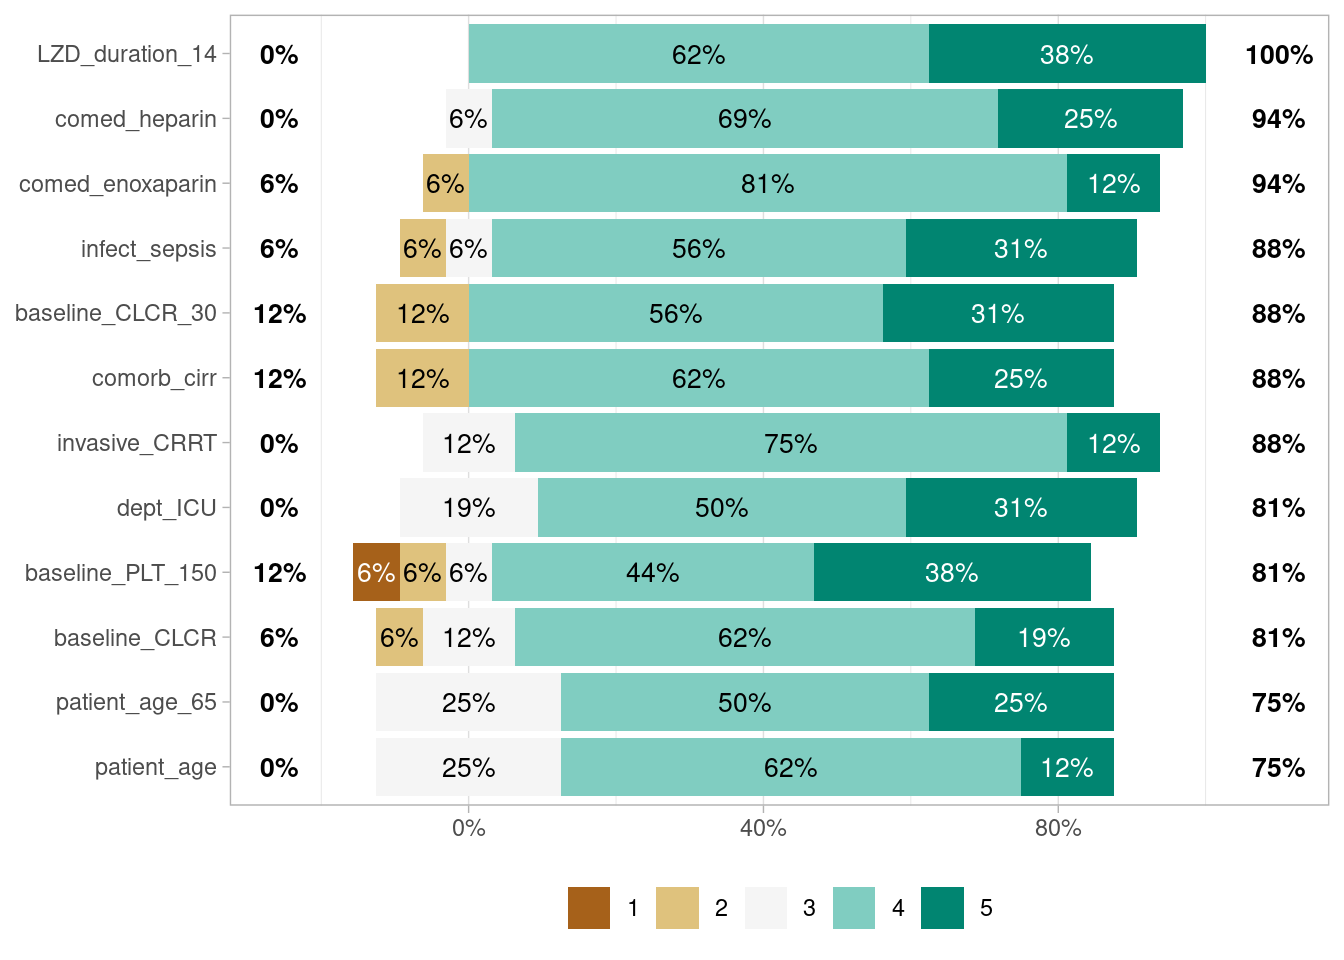

In [ ]:
# table_survey_summary <- data_survey |>
#   tbl_summary(type = ~"continuous", statistic = list(all_continuous() ~ "{mean} | {median} ({p25} - {p75})"))

calculate_prop <- function(x) {
  sum(x == 4 | x == 5) / length(x)
}

survey_summary <- data_survey |>
  summarise(across(everything(), list(prop = calculate_prop, median = median, IQR = IQR, mean = mean, sd = sd), .names = "{.fn}.{.col}")) |>
  pivot_longer(
    cols = everything(),
    names_to = c(".value", "variable"),
    names_pattern = "(prop|mean|median|IQR|sd)\\.(.*)"
  )

variables_consensus <- survey_summary |>
  filter(prop >= 0.7) |>
  arrange(desc(prop), desc(mean)) |>
  pull(variable)

data_survey_factor |>
  select(any_of(variables_consensus)) |>
  gglikert(sort = "descending", sort_method = "prop")


In [ ]:
data_patient_screen_full <- data_patient_transformed |>
  mutate(
    across(where(is.logical), as.factor)
  )

# Assuming `data_patient_screen_full` is your data frame
single_level_factors <- data_patient_screen_full |>
  purrr::map_lgl(~ is.factor(.x) && length(levels(.x)) == 1)

# Print the names of the variables that are factors with only one level
variables_to_remove <- names(single_level_factors)[single_level_factors]


In [ ]:
variables_to_screen_short <- variables_consensus |>
  str_replace_all("_\\d+", "") |>
  str_replace("LZD_duration", "LZD_duration_14") |>
  str_replace("dept_ICU|dept_ER", "dept_ICU_ER") |>
  unique()


In [ ]:
variables_to_screen_short_binary <- variables_consensus |>
  str_replace_all("_\\d+", "") |>
  str_replace("LZD_duration", "LZD_duration_14") |>
  str_replace("baseline_CLCR", "baseline_CLCR_30") |>
  str_replace("dept_ICU|dept_ER", "dept_ICU_ER") |>
  unique()


In [ ]:
variables_to_screen_binary <- survey_summary |>
  arrange(desc(prop), desc(mean)) |>
  pull(variable) |>
  str_replace_all("_\\d+", "") |>
  str_replace("LZD_duration", "LZD_duration_14") |>
  str_replace("baseline_CLCR", "baseline_CLCR_30") |>
  str_replace("dept_ICU|dept_ER", "dept_ICU_ER") |>
  unique() |>
  head(21)


In [ ]:
variables_to_screen <- survey_summary |>
  arrange(desc(prop), desc(mean)) |>
  pull(variable) |>
  str_replace_all("_\\d+", "") |>
  str_replace("LZD_duration", "LZD_duration_14") |>
  str_replace("dept_ICU|dept_ER", "dept_ICU_ER") |>
  unique() |>
  head(21)

variables_to_force <- variables_to_screen[1:5]

variables_to_force_top_3 <- variables_to_screen[1:3]

variables_out <- survey_summary |>
  filter(!variable %in% variables_to_screen)


In [ ]:
variables_to_force_binary <- survey_summary |>
  arrange(desc(prop), desc(mean)) |>
  pull(variable) |>
  head(5)


In [ ]:
variables_to_screen_all <- survey_summary |>
  arrange(desc(prop), desc(mean)) |>
  filter(!variable == "LZD_route_PO") |>
  pull(variable) |>
  str_replace_all("_\\d+", "") |>
  str_replace("LZD_duration", "LZD_duration_14") |>
  str_replace("dept_ICU|dept_ER", "dept_ICU_ER") |>
  unique() |>
  setdiff(variables_to_remove)


In [ ]:
variables_to_screen_all_binary <- survey_summary |>
  arrange(desc(prop), desc(mean)) |>
  filter(!variable == "LZD_route_PO") |>
  pull(variable) |>
  str_replace_all("_\\d+", "") |>
  str_replace("LZD_duration", "LZD_duration_14") |>
  str_replace("baseline_CLCR", "baseline_CLCR_30") |>
  str_replace("dept_ICU|dept_ER", "dept_ICU_ER") |>
  unique() |>
  setdiff(variables_to_remove)


In [ ]:
save(variables_to_screen, file = "data/results/variables-to-screen.rda")
save(variables_to_screen_short, file = "data/results/variables-to-screen-short.rda")
save(variables_to_screen_short_binary, file = "data/results/variables-to-screen-short-binary.rda")

save(variables_to_screen_binary, file = "data/results/variables-to-screen-binary.rda")
save(variables_to_screen_all, file = "data/results/variables-to-screen-all.rda")
save(variables_to_screen_all_binary, file = "data/results/variables-to-screen-all-binary.rda")

save(variables_to_force, file = "data/results/variables-to-force.rda")
save(variables_to_force_binary, file = "data/results/variables-to-force-binary.rda")
save(variables_to_force_top_3, file = "data/results/variables-to-force-top-3.rda")
